# Imports

In [ ]:
import gdown
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel


from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Getting the Data

In [ ]:
# Uploaded on my google drive: https://drive.google.com/drive/folders/1yhCZs6Q1EYieMLtAmc09h7MCt6AHlpkO?usp=sharing
# Kaggle link: https://www.kaggle.com/competitions/home-credit-default-risk/data

# File IDs for application_train.csv and application_test.csv
train_file_id = '1p03cnWg2z0InrxhXPIPtWwe1nPku1qBs'
test_file_id = '1iVFCHvNqYunRSXUF3DRSECszNQZmTjIb'

# Base URL for downloading from Google Drive
base_url = 'https://drive.google.com/uc?export=download&id='

# Complete URLs
train_url = base_url + train_file_id
test_url = base_url + test_file_id

# Download the files using gdown
gdown.download(train_url, 'application_train.csv', quiet=False)
gdown.download(test_url, 'application_test.csv', quiet=False)



Downloading...
From (original): https://drive.google.com/uc?export=download&id=1p03cnWg2z0InrxhXPIPtWwe1nPku1qBs
From (redirected): https://drive.google.com/uc?export=download&id=1p03cnWg2z0InrxhXPIPtWwe1nPku1qBs&confirm=t&uuid=fccc08a1-5a40-4cbb-bbd3-60025260f001
To: /content/application_train.csv
100%|██████████| 166M/166M [00:01<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1iVFCHvNqYunRSXUF3DRSECszNQZmTjIb
To: /content/application_test.csv
100%|██████████| 26.6M/26.6M [00:00<00:00, 52.3MB/s]


'application_test.csv'

# Read Data

In [ ]:
df_train = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')

In [ ]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


<Axes: ylabel='Frequency'>

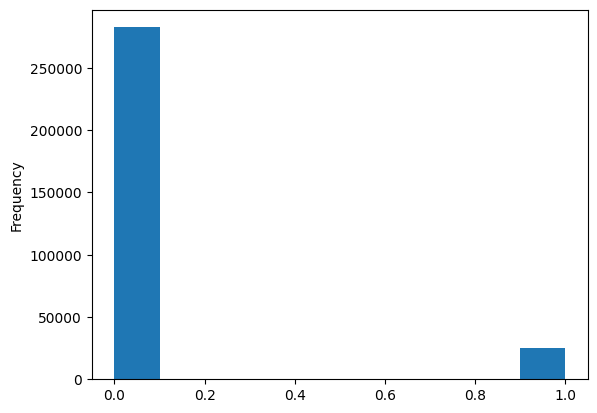

In [ ]:
df_train['TARGET'].astype(int).plot.hist()

## Function to calculate missing values

In [ ]:
df_train.isnull().sum()

,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519


In [ ]:
def missing_values_summary(df):
    missing_count = df.isnull().sum()

    missing_percentage = (missing_count / len(df)) * 100

    missing_summary = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage': missing_percentage
    })

    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

    missing_summary = missing_summary.sort_values(by='Missing Count', ascending=False)

    return missing_summary


missing = missing_values_summary(df_train)

missing.head(20)

,Missing Count,Missing Percentage
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


## EDA

In [ ]:
df_train.dtypes.value_counts()

,count
float64,65
int64,41
object,16


In [ ]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


# Encoding

In [ ]:
encoder = LabelEncoder()
count = 0

for col in df_train:
    if df_train[col].dtype == 'object':
        if len(list(df_train[col].unique())) <= 2:
            count +=1
            encoder.fit(df_train[col])
            df_train[col] = encoder.transform(df_train[col])
            df_test[col] = encoder.transform(df_test[col])


print('No of columns transformed: {}'.format(count))

No of columns transformed: 3


In [ ]:
#one hot encoding
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [ ]:
print(df_train.shape)
print(df_test.shape)

(307511, 243)
(48744, 239)


In [ ]:
train_labels = df_train['TARGET']

#columns which are unique
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

#adding the target variable
df_train['TARGET'] = train_labels

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [ ]:
#dividing by -365 to account for relativity to current loan time
(df_train['DAYS_BIRTH'] / -365).describe()


,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [ ]:
df_train['DAYS_EMPLOYED'].describe()


,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


seems to be not legit as max years is 1000 years and min is negative

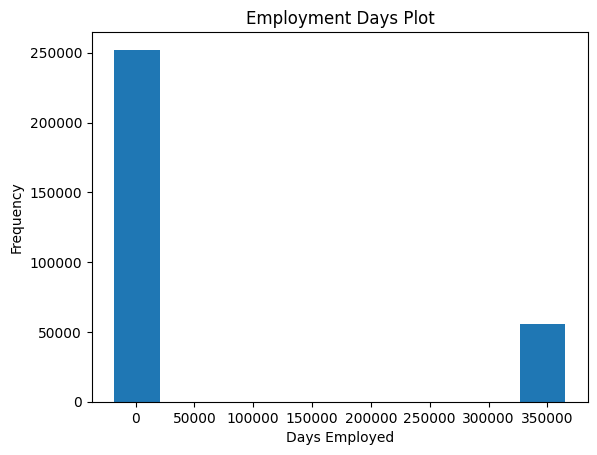

In [ ]:
df_train['DAYS_EMPLOYED'].plot.hist(title = 'Employment Days Plot');
plt.xlabel('Days Employed');

In [ ]:
anom = df_train[df_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_train[df_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Anomalies have lower rate of loans. Not a surprise. The anomalies do seem to have some importance.

Text(0.5, 0, 'Days Employment')

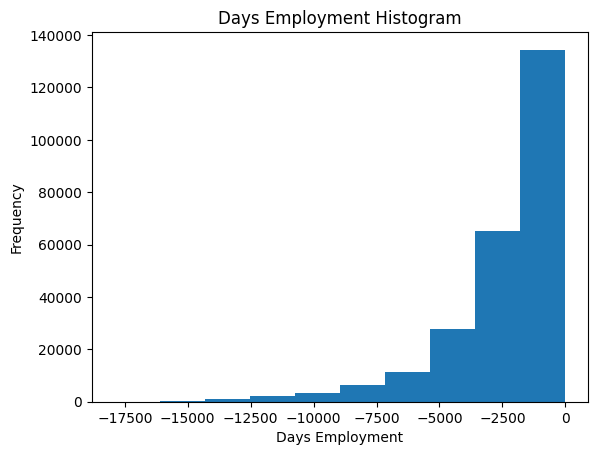

In [ ]:
#create anomalous example column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243

# Replace anomalous with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

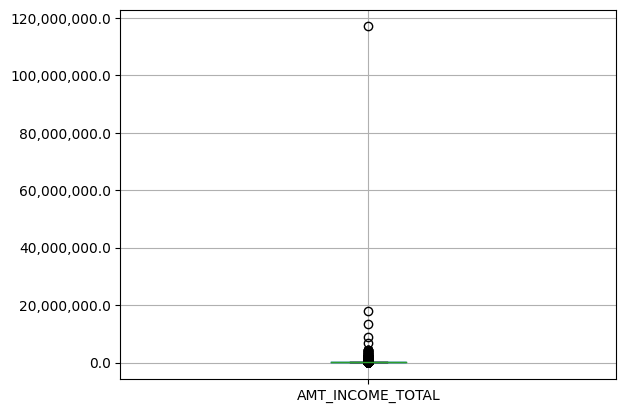

In [ ]:
df_train.boxplot(column=['AMT_INCOME_TOTAL'])
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, ',')))
plt.show()


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_train['AMT_INCOME_TOTAL'].describe()

,AMT_INCOME_TOTAL
count,307511.00
mean,168797.92
std,237123.15
min,25650.00
25%,112500.00
50%,147150.00
75%,202500.00
max,117000000.00


In [ ]:
df_train['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(10)


,AMT_INCOME_TOTAL
12840,117000000.00
203693,18000090.00
246858,13500000.00
77768,9000000.00
131127,6750000.00
287463,4500000.00
103006,4500000.00
187833,4500000.00
204564,4500000.00
181698,3950059.50


In [ ]:
df_train = df_train[df_train['AMT_INCOME_TOTAL'] < 5_000_000]
df_test = df_test[df_test['AMT_INCOME_TOTAL'] < 5_000_000]

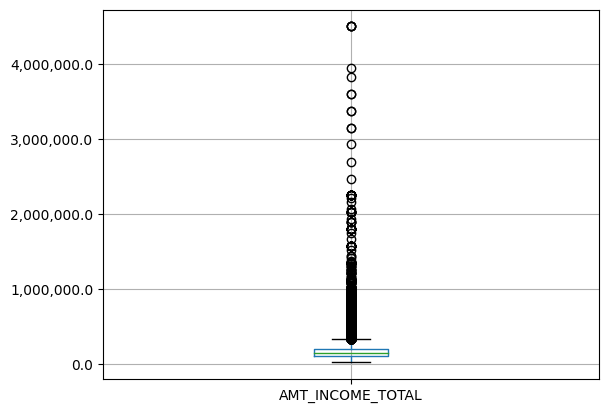

In [ ]:
df_train.boxplot(column=['AMT_INCOME_TOTAL'])
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(x, ',')))
plt.show()

<h2> LIGHTGBM Model</h2>

In [ ]:
y = df_train['TARGET'].values
train = df_train.drop(columns=['TARGET'])
print(train.shape)


(307506, 240)


In [ ]:
df_train.shape

(307506, 241)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, stratify=y, random_state=1)
print('Train shape:', x_train.shape)
print('Test shape:', x_test.shape)


Train shape: (215254, 240)
Test shape: (92252, 240)


In [ ]:


smote = RandomUnderSampler(random_state = 42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([17377, 17377]))

In [ ]:
#fix special character error in colnames
x_train = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_test = x_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
model = LGBMClassifier(
        n_estimators=300,
        num_leaves=15,
        colsample_bytree=.8,
        subsample=.8,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01
    )

model.fit(x_train,y_train, eval_metric='auc')

[LightGBM] [Info] Number of positive: 17377, number of negative: 17377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10992
[LightGBM] [Info] Number of data points in the train set: 34754, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(colsample_bytree=0.8, max_depth=7, min_split_gain=0.01,
               n_estimators=300, num_leaves=15, reg_alpha=0.1, reg_lambda=0.1,
               subsample=0.8)

In [ ]:
y_pred = model.predict(x_test)
y_pred_class = [1 if x > 0.5 else 0 for x in y_pred]

accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print the predictions
print(f'Predicted classes: {y_pred_class}')
print(f'Predicted probabilities: {y_pred}')


Accuracy: 69.09%
Predicted classes: [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 

In [ ]:
class_report = classification_report(y_test, y_pred_class)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     84805
           1       0.16      0.69      0.26      7447

    accuracy                           0.69     92252
   macro avg       0.56      0.69      0.53     92252
weighted avg       0.90      0.69      0.76     92252



<h2> Feature importance </h2>

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

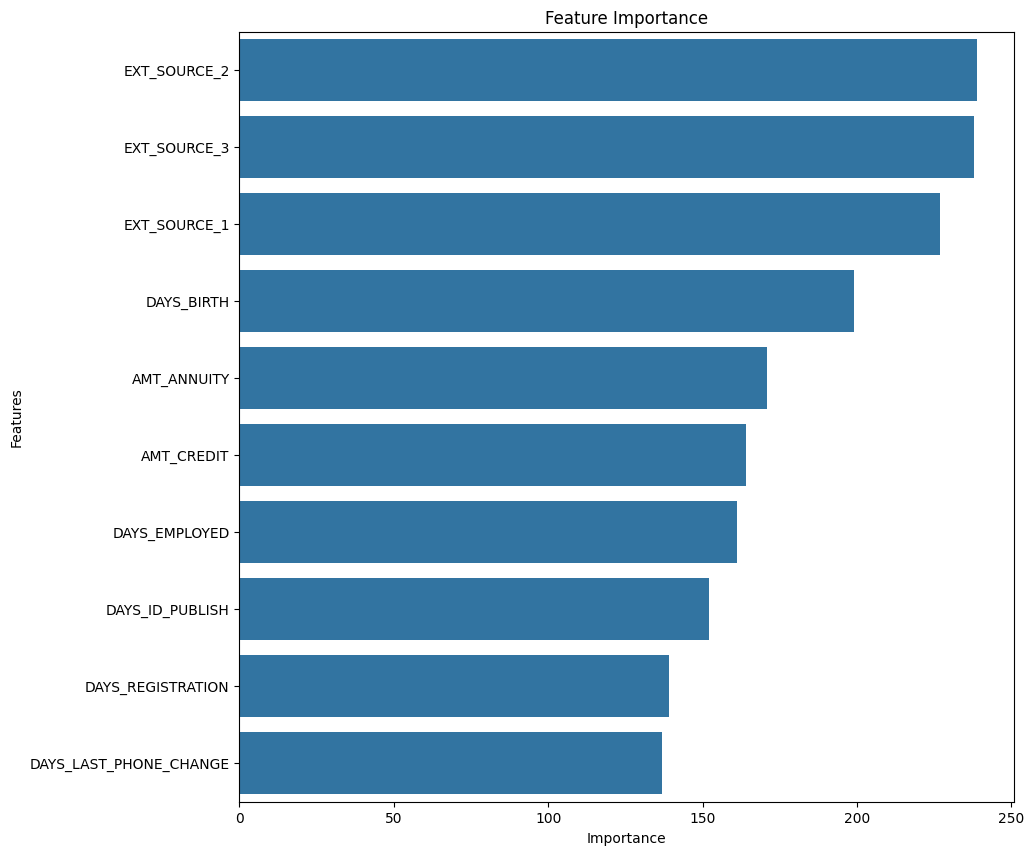

In [ ]:
importance  = model.feature_importances_

sort_idx = np.argsort(importance)[::-1]
sort_importance = importance[sort_idx]
sort_features = x_train.columns[sort_idx]

top_feats = sort_features[:10]
top_imp  = sort_importance[:10]
plt.figure(figsize=(10,10))
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
sns.barplot(x=top_imp, y=top_feats)

In [ ]:
filtered_feats = sort_features[:10]

df_filtered = df_train[filtered_feats]

df_filtered.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,AMT_ANNUITY,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE
0,0.26,0.14,0.08,-9461,24700.50,406597.50,-637.00,-2120,-3648.00,-1134.00
1,0.62,NaN,0.31,-16765,35698.50,1293502.50,-1188.00,-291,-1186.00,-828.00
2,0.56,0.73,NaN,-19046,6750.00,135000.00,-225.00,-2531,-4260.00,-815.00
3,0.65,NaN,NaN,-19005,29686.50,312682.50,-3039.00,-2437,-9833.00,-617.00
4,0.32,NaN,NaN,-19932,21865.50,513000.00,-3038.00,-3458,-4311.00,-1106.00


In [ ]:
df_filtered = df_filtered.fillna(df_filtered.median())
df_filtered.head()

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,AMT_ANNUITY,AMT_CREDIT,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE
0,0.26,0.14,0.08,-9461,24700.50,406597.50,-637.00,-2120,-3648.00,-1134.00
1,0.62,0.54,0.31,-16765,35698.50,1293502.50,-1188.00,-291,-1186.00,-828.00
2,0.56,0.73,0.51,-19046,6750.00,135000.00,-225.00,-2531,-4260.00,-815.00
3,0.65,0.54,0.51,-19005,29686.50,312682.50,-3039.00,-2437,-9833.00,-617.00
4,0.32,0.54,0.51,-19932,21865.50,513000.00,-3038.00,-3458,-4311.00,-1106.00


<h2>Logistic regression</h2>

In [ ]:
x_train_filtered, x_test_filtered, y_train_filtered, y_test_filtered = train_test_split(df_filtered, y, test_size=0.2, stratify=y, random_state = 1)

smote = RandomUnderSampler(random_state = 42)
x_train_filtered, y_train_filtered = smote.fit_resample(x_train_filtered, y_train_filtered)

In [ ]:
sc_X = StandardScaler()
x_train_filtered = sc_X.fit_transform(x_train_filtered)
x_test_filtered = sc_X.transform(x_test_filtered)

In [ ]:
np.unique(y_train_filtered, return_counts=True)

(array([0, 1]), array([19859, 19859]))

In [ ]:


model = LogisticRegression()
model.fit(x_train_filtered, y_train_filtered)


LogisticRegression()

In [ ]:
y_pred = model.predict(x_test_filtered)
accuracy_score(y_test_filtered, y_pred)

0.6765958830607135

In [ ]:

class_report = classification_report(y_test_filtered, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56537
           1       0.15      0.65      0.25      4965

    accuracy                           0.68     61502
   macro avg       0.55      0.66      0.52     61502
weighted avg       0.89      0.68      0.75     61502



In [ ]:

model = SVC(kernel='rbf')
model.fit(x_train_filtered, y_train_filtered)

SVC()

In [ ]:
y_pred = model.predict(x_test_filtered)
accuracy_score(y_test_filtered, y_pred)

0.6772625280478684

In [ ]:
class_report = classification_report(y_test_filtered, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56537
           1       0.15      0.66      0.25      4965

    accuracy                           0.68     61502
   macro avg       0.56      0.67      0.52     61502
weighted avg       0.89      0.68      0.75     61502



<h2>RandomForest based feature selection </h2<>

In [ ]:


x_train.fillna(x_train.median(), inplace=True)
x_test.fillna(x_test.median(), inplace=True)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)



RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)


0.7609157525040108

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     84805
           1       0.18      0.53      0.26      7447

    accuracy                           0.76     92252
   macro avg       0.56      0.66      0.56     92252
weighted avg       0.89      0.76      0.81     92252



In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.head(10)

,0
EXT_SOURCE_3,0.06
EXT_SOURCE_2,0.06
DAYS_BIRTH,0.03
DAYS_EMPLOYED,0.03
DAYS_ID_PUBLISH,0.03
DAYS_LAST_PHONE_CHANGE,0.03
EXT_SOURCE_1,0.03
DAYS_REGISTRATION,0.03
AMT_ANNUITY,0.03
AMT_CREDIT,0.03


In [ ]:
feats_new = feature_importances[:10].index
feats_new

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_1',
       'DAYS_REGISTRATION', 'AMT_ANNUITY', 'AMT_CREDIT'],
      dtype='object')

<h2>Logistic regression</h2>

In [ ]:
model = LogisticRegression()
x_train_new = x_train[feats_new]
x_test_new = x_test[feats_new]
model.fit(x_train_new, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.6517257078437324

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.67      0.78     84805
           1       0.11      0.44      0.17      7447

    accuracy                           0.65     92252
   macro avg       0.52      0.56      0.48     92252
weighted avg       0.87      0.65      0.73     92252



<h2>SVM</h2>

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(x_train_new, y_train)

SVC()

In [ ]:
y_pred = svm.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.5004986341759529

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.94      0.49      0.64     84805
           1       0.10      0.63      0.17      7447

    accuracy                           0.50     92252
   macro avg       0.52      0.56      0.41     92252
weighted avg       0.87      0.50      0.60     92252



<h2>XGBOOST feature seelction </h2>

In [ ]:


model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7638208385726055

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     84805
           1       0.17      0.51      0.26      7447

    accuracy                           0.76     92252
   macro avg       0.56      0.65      0.56     92252
weighted avg       0.89      0.76      0.81     92252



In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.head(10)

,0
EXT_SOURCE_3,0.02
NAME_EDUCATION_TYPE_Highereducation,0.02
EXT_SOURCE_2,0.02
NAME_INCOME_TYPE_Pensioner,0.01
NAME_TYPE_SUITE_Other_A,0.01
ORGANIZATION_TYPE_Agriculture,0.01
CODE_GENDER_F,0.01
EXT_SOURCE_1,0.01
NAME_CONTRACT_TYPE,0.01
FLOORSMIN_MODE,0.01


In [ ]:
feats_new = feature_importances[:10].index
feats_new

Index(['EXT_SOURCE_3', 'NAME_EDUCATION_TYPE_Highereducation', 'EXT_SOURCE_2',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_TYPE_SUITE_Other_A',
       'ORGANIZATION_TYPE_Agriculture', 'CODE_GENDER_F', 'EXT_SOURCE_1',
       'NAME_CONTRACT_TYPE', 'FLOORSMIN_MODE'],
      dtype='object')

<h2>Logistic Regression </h2>

In [ ]:
model = LogisticRegression()
x_train_new = x_train[feats_new]
x_test_new = x_test[feats_new]
model.fit(x_train_new, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.7131552703464423

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     84805
           1       0.16      0.61      0.25      7447

    accuracy                           0.71     92252
   macro avg       0.56      0.66      0.54     92252
weighted avg       0.89      0.71      0.78     92252



<h2>SVM</h2>

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(x_train_new, y_train)

SVC()

In [ ]:
y_pred = svm.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.6982396045614188

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     84805
           1       0.16      0.63      0.25      7447

    accuracy                           0.70     92252
   macro avg       0.56      0.67      0.53     92252
weighted avg       0.89      0.70      0.77     92252



<h2>Catboost feature selection</h2>

In [ ]:


model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='Logloss', random_seed=42)
model.fit(x_train, y_train)

0:	learn: 0.6790094	total: 83.8ms	remaining: 8.3s
1:	learn: 0.6682444	total: 114ms	remaining: 5.57s
2:	learn: 0.6596636	total: 166ms	remaining: 5.36s
3:	learn: 0.6526703	total: 206ms	remaining: 4.95s
4:	learn: 0.6452627	total: 257ms	remaining: 4.89s
5:	learn: 0.6404380	total: 309ms	remaining: 4.84s
6:	learn: 0.6356657	total: 370ms	remaining: 4.91s
7:	learn: 0.6314439	total: 427ms	remaining: 4.91s
8:	learn: 0.6277043	total: 477ms	remaining: 4.82s
9:	learn: 0.6242814	total: 529ms	remaining: 4.76s
10:	learn: 0.6210877	total: 582ms	remaining: 4.71s
11:	learn: 0.6183275	total: 637ms	remaining: 4.67s
12:	learn: 0.6164815	total: 691ms	remaining: 4.63s
13:	learn: 0.6143736	total: 747ms	remaining: 4.59s
14:	learn: 0.6124882	total: 799ms	remaining: 4.53s
15:	learn: 0.6110444	total: 871ms	remaining: 4.57s
16:	learn: 0.6094602	total: 928ms	remaining: 4.53s
17:	learn: 0.6081291	total: 981ms	remaining: 4.47s
18:	learn: 0.6067759	total: 1.03s	remaining: 4.39s
19:	learn: 0.6055110	total: 1.07s	remaini

In [ ]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7829532151064476

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     84805
           1       0.19      0.52      0.28      7447

    accuracy                           0.78     92252
   macro avg       0.57      0.67      0.58     92252
weighted avg       0.89      0.78      0.82     92252



In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.head(10)

,0
EXT_SOURCE_3,19.72
EXT_SOURCE_2,17.42
EXT_SOURCE_1,8.62
DAYS_BIRTH,4.28
AMT_GOODS_PRICE,4.01
AMT_CREDIT,3.73
DAYS_EMPLOYED,3.65
AMT_ANNUITY,2.85
NAME_EDUCATION_TYPE_Highereducation,2.31
DAYS_ID_PUBLISH,2.15


<h2>Logistic Regression</h2>

In [ ]:
model = LogisticRegression()
x_train_new = x_train[feats_new]
x_test_new = x_test[feats_new]
model.fit(x_train_new, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.7131552703464423

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     84805
           1       0.16      0.61      0.25      7447

    accuracy                           0.71     92252
   macro avg       0.56      0.66      0.54     92252
weighted avg       0.89      0.71      0.78     92252



<h2>Support Vector machine</h2>

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(x_train_new, y_train)

SVC()

In [ ]:
y_pred = svm.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.6982396045614188

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     84805
           1       0.16      0.63      0.25      7447

    accuracy                           0.70     92252
   macro avg       0.56      0.67      0.53     92252
weighted avg       0.89      0.70      0.77     92252



<h2>Adaboost feature selection </h2>

In [ ]:

model = AdaBoostClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [ ]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8147682435069158

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.85      0.89     84805
           1       0.20      0.44      0.28      7447

    accuracy                           0.81     92252
   macro avg       0.57      0.65      0.59     92252
weighted avg       0.89      0.81      0.84     92252



In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.head(10)

,0
EXT_SOURCE_2,0.13
EXT_SOURCE_3,0.12
EXT_SOURCE_1,0.05
AMT_ANNUITY,0.05
DAYS_EMPLOYED,0.04
DAYS_BIRTH,0.04
AMT_CREDIT,0.03
DAYS_ID_PUBLISH,0.03
HOUR_APPR_PROCESS_START,0.02
OWN_CAR_AGE,0.02


In [ ]:
x_train_new = x_train[feats_new]
x_test_new = x_test[feats_new]

<h2>Logistic Regression </h2>

In [ ]:
model = LogisticRegression()
model.fit(x_train_new, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.7131552703464423

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     84805
           1       0.16      0.61      0.25      7447

    accuracy                           0.71     92252
   macro avg       0.56      0.66      0.54     92252
weighted avg       0.89      0.71      0.78     92252



<h2>SVM</h2>

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(x_train_new, y_train)

SVC()

In [ ]:
y_pred = svm.predict(x_test_new)
accuracy_score(y_test, y_pred)

0.6982396045614188

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     84805
           1       0.16      0.63      0.25      7447

    accuracy                           0.70     92252
   macro avg       0.56      0.67      0.53     92252
weighted avg       0.89      0.70      0.77     92252

